In [1]:
a = 3.             #width of a well
b = 3.             #width of a barrier
V = 1.0             #height of a barrier
N = 355               #fragmentation of Brillouin zone from 0 to pi/(a+b)
N_r = 80        #fragmentation of lattice (for counting integrals in F)
A_SC = 0.955*0.88                #parameter in SC kernel
alph = 0.01*0.89                 #another parameter in SC
A_cont = 3.77            #parameter in contact kernel
A_LR = 15.  

In [195]:
a = 0.5
b = 0.5 
V = 20.0  
N = 151 
N_r = 80 
A_SC = 2.39*4.1
alph = 0.01 
A_cont = 100.   
A_LR = 15.  

In [143]:
a = 2.6 
b = 0.4 
V = 8.0  
N = 271 
N_r = 90
A_SC = 0.898*1.4
alph = 0.01
A_cont = 3.7 #2.32
A_LR = 15.  

In [2]:
import numpy
import scipy.special as spc
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
from scipy.integrate import simps
from scipy.integrate import trapz
import cmath
Volume = numpy.sqrt(N)*(a+b)
E_k = lambda E: (cmath.cos(cmath.sqrt(2*E)*a) * cmath.cosh(b * cmath.sqrt(2 * V - 2 * E)) + \
                   (V / (2*E) - 1.) / cmath.sqrt(V/E - 1.) * cmath.sinh(cmath.sqrt(2*V - 2*E)*b) * \
                    cmath.sin(cmath.sqrt(2*E)*a) - cmath.cos(k * (a+b))).real
k_map = numpy.linspace(-numpy.pi/(a+b),numpy.pi/(a+b),N)
#r_map = numpy.arange(0,N_r) * (a+b) / N_r - b
r_map = numpy.linspace(-b,a,N_r)
for i in range (0, N_r):
    if (r_map[i]<=0):
        N_0 = i
h = r_map[1] - r_map[0]


Ниже выводится график зонной структуры.
Построение зонной структуры происходит по формуле 
$$
cos (ka+kb) = cos (\sqrt{2 \epsilon} a) ch (\sqrt{2V_0 - 2\epsilon} b) + \frac{\frac{V_0}{2\epsilon} - 1}{\sqrt{ \frac{V}{\epsilon} - 1}} sin (\sqrt{2 \epsilon} a) sh (\sqrt{2V_0-2\epsilon} b) 
$$

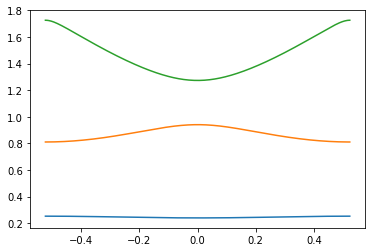

In [3]:
Func = lambda E: cmath.cos(cmath.sqrt(2*E)*a) * cmath.cosh(b * cmath.sqrt(2 * V - 2 * E)) + \
                   (V / (2*E) - 1.) / cmath.sqrt(V/E - 1.) * cmath.sinh(cmath.sqrt(2*V - 2*E)*b) * \
                    cmath.sin(cmath.sqrt(2*E)*a)
E_border = numpy.zeros(6)
E_map = numpy.zeros((N,3))
e = 0.; zone = 0; checker = False
while zone < 3:
    e = e + V/1000.
    if abs(Func(e))<=1 and checker == False:
        E_border[2*zone] = e
        checker = True
    if abs(Func(e))>1 and checker == True:
        E_border[2*zone+1] = e - V/1000.
        checker = False
        zone = zone + 1
fig,ax = plt.subplots()
for zone in range (0,3):
    for i in range (0,N):
        k = k_map[i]
        l = opt.fsolve(E_k, (E_border[2*zone+1] + E_border[2*zone])/2.)
        E_map[i,zone] = l[0]
    ax.plot(k_map, E_map[:,zone])
plt.show()

В следующем блоке считаются значения волновой функции *fi* в узловых точках по прямой и обратной ячейке решетки.

\begin{equation}
\begin{cases}
   \psi_{k1} (x) =   A_1 sin(\sqrt{2\epsilon} x) + A_2 cos ( \sqrt{2\epsilon} x) &\text{0 < x < a}\\
   \psi_{k2} (x) = A_1 \frac{\sqrt{2\epsilon}}{\sqrt{2V-2\epsilon}} sh(\sqrt{2\epsilon-2V_0} x) + A_2 ch( \sqrt{2\epsilon-2V_0} x) &\text{-b < x < 0}
 \end{cases}
\end{equation}

In [4]:
fi = numpy.zeros((N_r,N,2),dtype = complex)
opt = numpy.zeros((N,4),dtype = complex)
X_full = [[],[]]
for zone in range (0,2):
    opt[:,zone] = numpy.sqrt(2.*E_map[:,zone+1])
    opt[:,zone+2] = numpy.sqrt(2.*(E_map[:,zone+1] - V), dtype=complex)
for z in range (0,2):
    for i in range (0,N):
        k = k_map[i]
        A = numpy.array([[1.,1.,-1.],[-opt[i,z],opt[i,z],opt[i,z+2]],[cmath.exp(-1.j*k*(a+b)-1.j*a*opt[i,z]),\
                            cmath.exp(-1.j*k*(a+b)+1.j*a*opt[i,z]),-cmath.exp(1.j*opt[i,z+2]*b)]],dtype=complex)
        B = numpy.array([1.,opt[i,z+2],cmath.exp(-1.j*opt[i,z+2]*b)],dtype=complex)
        X=numpy.linalg.solve(A,B)
        X = numpy.append(X[:], [1.])
        X_full[z].append(X)
X_full = numpy.array(X_full)
for z in range (0,2):
    for x in range (0,N_0):
        fi[x,:,z] = X_full[z,:,2]*numpy.exp(-1.j*opt[:,z+2]*r_map[x],dtype=complex)+\
            X_full[z,:,3]*numpy.exp(1.j*opt[:,z+2]*r_map[x],dtype=complex)
    for x in range (N_0,N_r):
        fi[x,:,z] = X_full[z,:,0]*numpy.exp(-1.j*opt[:,z]*r_map[x],dtype=complex)+\
            X_full[z,:,1]*numpy.exp(1.j*opt[:,z]*r_map[x],dtype=complex)
    for i in range (0,N):
        norm = simps(abs(fi[:,i,z])**2,x=None,dx=h)
        fi[:,i,z] = fi[:,i,z] * cmath.sqrt((a+b)/norm)

Этот блок считает $F^{vcvc}$ посредством Soft-Colomb ядра $f_{xc}^{SC}(x,x')=\frac{-A^{SC}}{\sqrt{\alpha+(x-x')^2}}$

Само F определяется как $F_{HXC,\bf{k},\bf{k'}}^{ijmn} = \frac{2}{\Omega^2} \int_{\Omega} d r\int_{\Omega} d r'\phi_{i,\bf{k}}^*(\bf{r}) \phi_{j,\bf{k}}^*(\bf{r}) f_{HXC} (\bf{r}, \bf{r'}, \omega) \phi_{m,\bf{k'}}^*(\bf{r'}) \phi_{n,\bf{k'}}^*(\bf{r'})$; здесь $\Omega$ - размер одномерной ячейки

In [5]:
F = numpy.zeros((N,N), dtype = complex)
def R_func(x,r): return A_SC * ((r_map[x]-r_map[r])**2+alph)**(-0.5)
R_SC = numpy.fromfunction(R_func, (N_r,N_r), dtype = int)
def f_func(x,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*R_SC[:,x],x=None,dx=h,axis=0)
f_SC = numpy.fromfunction(f_func, (N_r,N), dtype = int)
def F_func(i,j): return simps(f_SC[:,j]*fi[:,i,0].conj()*fi[:,i,1],x=None,dx=h,axis=0)*2/Volume**2
F = numpy.fromfunction(F_func,(N,N), dtype = int)

Этот блок считает F посредством контактного ядра $f_{xc}^{cont}(x,x')=-A^{cont}\delta (x-x')$

In [161]:
F = numpy.zeros((N,N), dtype = complex)
def f_cont(i,j): return simps(-fi[:,j,0]*fi[:,j,1].conj()*A_cont*fi[:,i,0].conj()*fi[:,i,1],x=None,dx=h,axis=0)*2/Volume**2 
F = numpy.fromfunction(f_cont,(N,N), dtype = int)

Здесь выводится матрца F(k,k'), а потом решается уравнение (21) как задача на поиск собственных векторов.

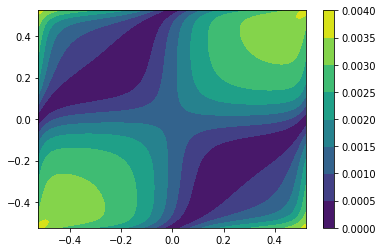

In [6]:
x, y = numpy.meshgrid(k_map, k_map)
fig = plt.contourf(x, y, abs(F))
plt.colorbar(fig)
for i in range(0, N):
    F[i,i] = F[i,i] + E_map[i,2] - E_map[i,1]
fr,v = numpy.linalg.eigh(F)

Вывод графиков зависимости квадрата плотности состояния $|\rho^{cv}(k)|^2$, которому соответсвует честота перехода w, от волнового числа. Num - порядковый номер собственного числа (и соответствующего собственного вектора)

0.07286924901735854
0.1338724691343552
0.33244988833571293


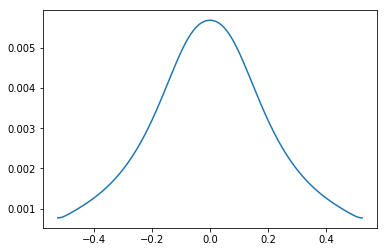

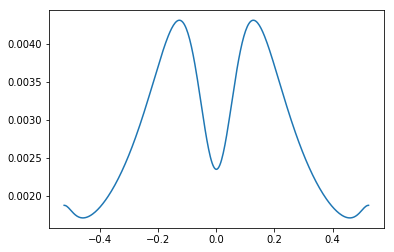

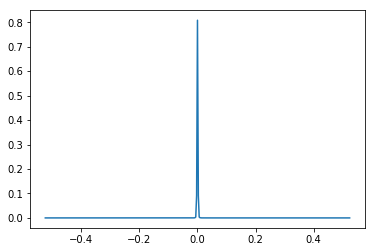

In [7]:
for num in range (0,3):
    fig, ax = plt.subplots()
    print(fr[num])
    ax.plot(k_map, (abs(v[:,num]))**2)
plt.show()

Здесь будет считаться $Im (\epsilon)$ и строиться ее график по формуле 

$
\epsilon_M=1-lim_{q->0} 4\pi \sum_{\lambda} \frac{|< c|e^{-iqr}|v > \rho^{cv}|^2}{\omega-\omega_{\lambda}+i\mu}
$

, где $< v|e^{-iqr}|c > = \int_{-b}^{a} \psi^v(r) e^{-iqr} \psi^{c*}(r) dr $, $\mu$ отвечает за сглаживание пиков на частотах, совпадающих с собственными частотами уравнения Ванье

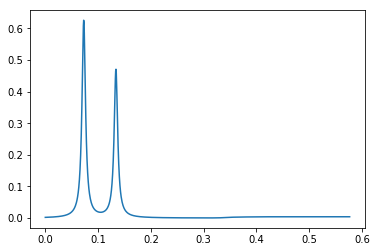

In [23]:
#correct formula but wrong spectrum
q=0.0013; N_w = 1000; eta = 0.004
w_map = numpy.linspace(0., fr[N // 2], N_w)
F_fr = numpy.zeros(numpy.size(w_map), dtype = complex)
Int = numpy.zeros(N, dtype = complex); ME = numpy.zeros(N, dtype = complex)
def integr(i):
    return simps(fi[:,i,1].conj()*fi[:,i,0]*numpy.exp(-1.j*q*r_map[:],dtype=complex),dx=h)
for i in range (0,N):
    Int[i] = integr(i)
ME[:] = abs(Int.dot(v[:])/(a+b))**2
for w in range (0, N_w):
    Int[:] = (w_map[w] - fr[:] + 1.j * eta) ** (-1)
    F_fr[w] = 1 - 4 * numpy.pi * Int.dot(ME)
fig, ax = plt.subplots()
ax.plot(w_map,F_fr.imag)
plt.show()

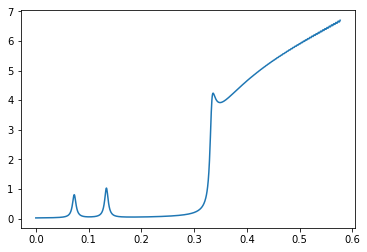

In [22]:
#gives proper spectrum
q=0.0013; N_w = 1000; eta = 0.004
w_map = numpy.linspace(0., fr[N // 2], N_w)
F_fr = numpy.zeros(numpy.size(w_map), dtype = complex)
Int = numpy.zeros(N, dtype = complex); ME = numpy.zeros(N, dtype = complex)
def integr(i):
    return simps(fi[:,i,1].conj()*fi[:,i,0]*numpy.exp(-1.j*q*r_map[:],dtype=complex),dx=h)
for i in range (0,N):
    Int[i] = abs(integr(i))**2
ME[:] = Int.dot(abs(v[:])**2)#/(a+b)
for w in range (0, N_w):
    Int[:] = (w_map[w] - fr[:] + 1.j * eta) ** (-1)
    F_fr[w] = 1 - 4 * numpy.pi * Int.dot(ME)*spc.k0(numpy.sqrt(alph)*q) 
fig, ax = plt.subplots()
ax.plot(w_map,F_fr.imag)
plt.show()